In [1]:
import numpy as np

import scipy.stats
from scipy import stats

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
def calculate_prior(y):
    return np.array([(y==0).sum(axis=0), (y==1).sum(axis=0)])/y.size
def calculate_mean(x, y):
    m = np.zeros((2, x.shape[1]))
    m[0] = x[y==0].mean(axis=0)
    m[1] = x[y==1].mean(axis=0)
    return m
def calculate_var(x, y):
    v = np.zeros((2, x.shape[1]))
    v[0] = x[y==0].var(axis=0)
    v[1] = x[y==1].var(axis=0)
    return v
def calculate_posterior(mean, var, x):
    n0 = stats.norm(mean[0], np.sqrt(var[0]))
    n1 = stats.norm(mean[1], np.sqrt(var[1]))
    a = n0.pdf(x).prod(axis=1)*prior[0]
    b = n1.pdf(x).prod(axis=1)*prior[1]
    return np.array([a/(a+b), b/(a+b)]).T
def model_validation(y_true, y_pred):
    cnfx = confusion_matrix(y_true, y_pred)
    [[tn, fp], [fn, tp]] = cnfx
    accuracy = (tn + tp)/(tn + fp + fn + tp)
    no, yes = cnfx.sum(axis=1)
    negative, positive = cnfx.sum(axis=0)
    recall = tp/yes
    precession = tp/positive
    fscore = lambda p, r, b: ((1 + b**2) * (p*r))/ (b**2 * p + r)
    f1 = fscore(precession, recall, 1)
    return np.array([accuracy, recall, precession, f1])

In [3]:
iris = datasets.load_iris()
cols = iris.feature_names
X = iris.data

In [4]:
TRAIN_TEST_RATIO = 0.8
M = X.shape[0]
M_train = int(np.ceil(0.8*M))

In [5]:
scaler = MinMaxScaler()
scaler = scaler.fit(X)
#X = scaler.transform(X)


indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:M_train], indices[M_train:]
X_train, X_test = X[train_idx, :], X[test_idx, :]

X_train = X_train[X_train[:,2].argsort()]
X_test = X_test[X_test[:,2].argsort()]

x_train, x_test = X_train[:, 0:2], X_test[:, 0:2]
y_train, y_test = X_train[:, 2], X_test[:, 2]

N_train = x_train.shape[1]

In [6]:
posterior = np.empty((0, M_train), np.float64)
validation = np.empty((0, 5), np.float64)
theta_mean_0 = np.empty((0, N_train), np.float64)
theta_var_0 = np.empty((0, N_train), np.float64)
theta_mean_1 = np.empty((0, N_train), np.float64)
theta_var_1 = np.empty((0, N_train), np.float64)

In [7]:
for i in range(1, M_train-10):
    y = (y_train>y_train[i])*1
    prior = calculate_prior(y)
    mean = calculate_mean(x_train, y)
    var = calculate_var(x_train, y)
    post = calculate_posterior(mean, var, x_train)
    val = model_validation(y, post.argmax(axis=1))
    val = np.append(val, [y_train[i]], axis=0)
    theta_mean_0 = np.append(theta_mean_0, mean[0,:].reshape(1,-1), axis=0)
    theta_var_0 = np.append(theta_var_0, var[0,:].reshape(1,-1), axis=0)
    theta_mean_1 = np.append(theta_mean_1, mean[1,:].reshape(1,-1), axis=0)
    theta_var_1 = np.append(theta_var_1, var[1,:].reshape(1,-1), axis=0)
    posterior = np.append(posterior, post[:,0].reshape(1,-1), axis=0)
    validation = np.append(validation, val.reshape(1,-1), axis=0)

In [8]:
posterior.shape

(109, 120)

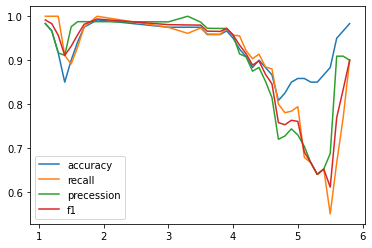

In [9]:
mat = ["accuracy", "recall", "precession", "f1"]
for i, k in enumerate(mat):
    plt.plot(validation[:, -1], validation[:, i], label=k)
plt.legend()
plt.show()

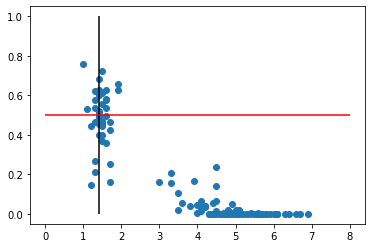

In [10]:
i = 10
plt.scatter(y_train, posterior[i, :])
plt.vlines(ymin=0, ymax=1, x=validation[:, -1][i], color="black")
plt.hlines(xmin=0, xmax=8, y=0.5, color="red")
plt.show()

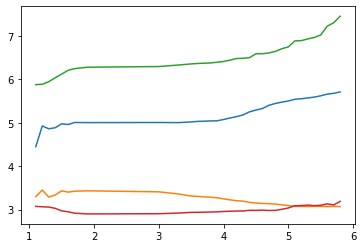

In [11]:
plt.plot(validation[:, -1], theta_mean_0)
plt.plot(validation[:, -1], theta_mean_1)

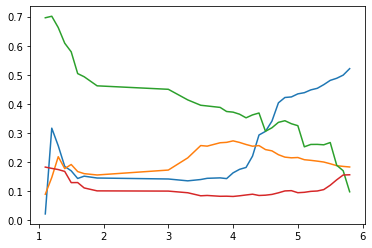

In [12]:
plt.plot(validation[:, -1], theta_var_0)
plt.plot(validation[:, -1], theta_var_1)